In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qbc import ActiveLearner, Committee
from utils import sign
from sklearn.linear_model import LogisticRegression

In [43]:
def run_experiments(
    data_mode: str = 'random',
    k: int = 10,
    d: int = 5,
    n: int = 500,
    q: int = 100,
    query_strategy: str = 'vote',
    repeat: int = 100,
    beta: float = 0.,
    byzantine_mode: str = 'flip',
    byzantine_proba: float = 0.5
):
    avg_total_perf_hist, avg_good_perf_hist = 0., 0.
    for instance in range(repeat):
        w = np.random.randn(d)
        if data_mode == 'single':
            X = np.column_stack([
                np.linspace(-10., 10., n),
                np.ones((n, d-1))
            ])
        else:
            X = np.random.randn(n, d) * 10. - 5. 
        Y = sign(X @ w)

        n_byzantine = int(beta * k)
        good_agents = np.arange(k)
        if n_byzantine >= 1:
            good_agents = np.random.choice(np.arange(k), size=k-n_byzantine, replace=False)
            good_agents.sort()
        learners = []

        for i in range(k):
            learner = ActiveLearner(
                estimator=LogisticRegression(penalty=None, fit_intercept=False),
                bootstrap_init=True
            )
            if i not in good_agents:
                learner.make_byzantine(byzantine_mode, byzantine_proba)
            learners.append(learner)

        committee = Committee(learners, strategy=query_strategy)

        good_perf_hist = [committee.score(X, Y, True)]
        total_perf_hist = [committee.score(X, Y)]
        X_pool = X.copy()
        Y_pool = Y.copy()
        X_seen = None
        Y_seen = None

        for i in range(q):
            query_idx, _ = committee.query(X_pool, random_tie_break=True)
            if X_seen is None or Y_seen is None:
                X_seen = X_pool[query_idx].reshape(1, -1)
                Y_seen = Y_pool[query_idx].reshape(-1,)
            else:
                X_seen = np.concatenate([X_seen, X_pool[query_idx].reshape(1, -1)], axis=0)
                Y_seen = np.concatenate([Y_seen, Y_pool[query_idx].reshape(-1,)])

            committee.teach(X_pool[query_idx].reshape(1, -1), Y_pool[query_idx].reshape(-1,), bag=True)
            good_perf_hist.append(committee.score(X, Y, True))
            total_perf_hist.append(committee.score(X, Y))

            X_pool = np.delete(X_pool, query_idx, axis=0)
            Y_pool = np.delete(Y_pool, query_idx)
        
        avg_total_perf_hist = (avg_total_perf_hist * instance + np.array(total_perf_hist).reshape(q+1,)) / (instance + 1)
        avg_good_perf_hist = (avg_good_perf_hist * instance + np.array(good_perf_hist).reshape(q+1,)) / (instance + 1)
    
    return avg_total_perf_hist, avg_good_perf_hist

def plot_learning_curve(total_perf_hist: np.array, good_perf_hist: np.array) -> None:
    length = len(total_perf_hist)
    plt.plot(range(length), good_perf_hist, label='Good learners')
    plt.plot(range(length), total_perf_hist, label='All learners', alpha=0.5)
    plt.plot(range(length), np.ones((length,)), linestyle='dashed')
    plt.xlabel('Query iteration')
    plt.ylabel('Accuracy of committee')
    plt.title('Learning curve')
    plt.legend()
    plt.show()

## Single data

The data for the following experiments has only one active dimension, i.e., $d-1$ dimensions are constant across all $n$ samples

### Random queries

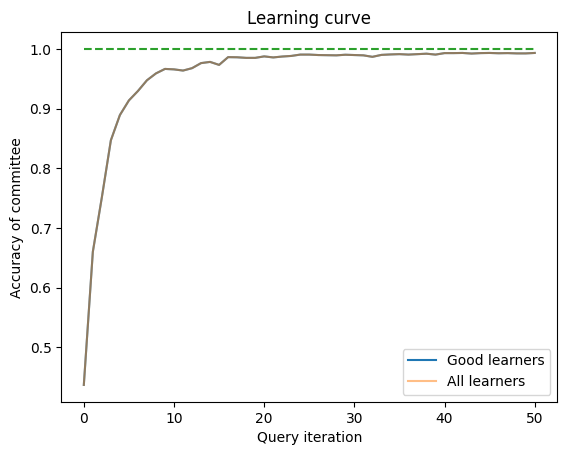

In [44]:
avg_total_perf_hist, avg_good_perf_hist = run_experiments('single', n=200, q=50, repeat=20, query_strategy='random')
plot_learning_curve(avg_total_perf_hist, avg_good_perf_hist)

### $\beta = 0$

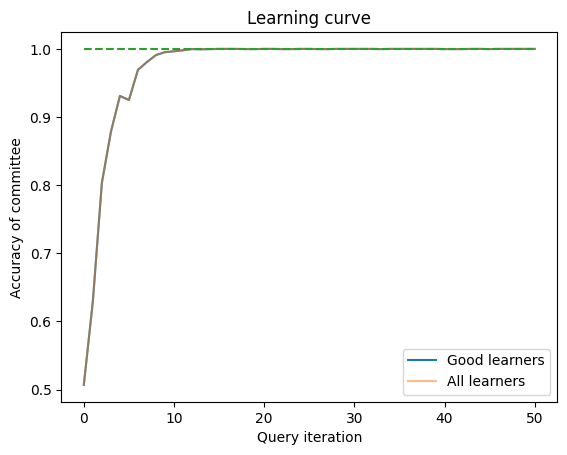

In [5]:
avg_total_perf_hist, avg_good_perf_hist = run_experiments('single', n=200, q=50, repeat=20)
plot_learning_curve(avg_total_perf_hist, avg_good_perf_hist)

### $\beta = 0.4$, flip w.p. $0.5$

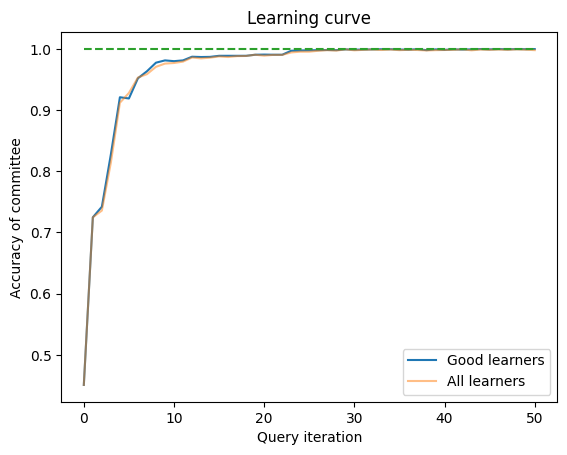

In [9]:
avg_total_perf_hist, avg_good_perf_hist = run_experiments('single', n=200, q=50, repeat=20, beta=0.4, byzantine_proba=0.5)
plot_learning_curve(avg_total_perf_hist, avg_good_perf_hist)

### $\beta = 0.5$, flip w.p. $0.5$

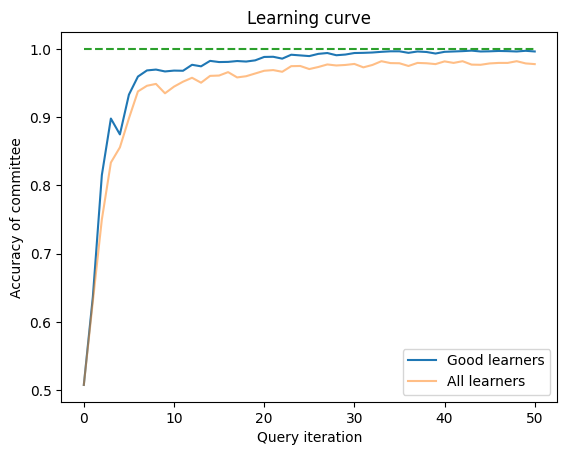

In [10]:
avg_total_perf_hist, avg_good_perf_hist = run_experiments('single', n=200, q=50, repeat=20, beta=0.5, byzantine_proba=0.5)
plot_learning_curve(avg_total_perf_hist, avg_good_perf_hist)

### $\beta = 0.6$, random w.p. $0.5$

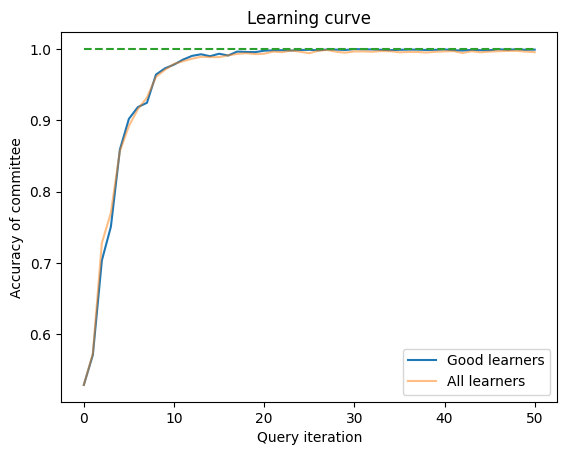

In [20]:
avg_total_perf_hist, avg_good_perf_hist = run_experiments('single', n=200, q=50, repeat=20, beta=0.6, byzantine_proba=0.5, byzantine_mode='rand')
plot_learning_curve(avg_total_perf_hist, avg_good_perf_hist)

### $\beta = 0.8$, random w.p. $0.5$

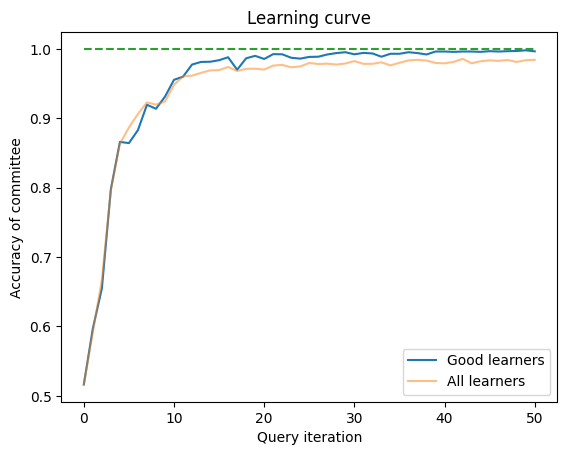

In [22]:
avg_total_perf_hist, avg_good_perf_hist = run_experiments('single', n=200, q=50, repeat=20, beta=0.8, byzantine_proba=0.5, byzantine_mode='rand')
plot_learning_curve(avg_total_perf_hist, avg_good_perf_hist)

## Random data

The following experiments are performed with all $d$ dimensions active

### Random queries

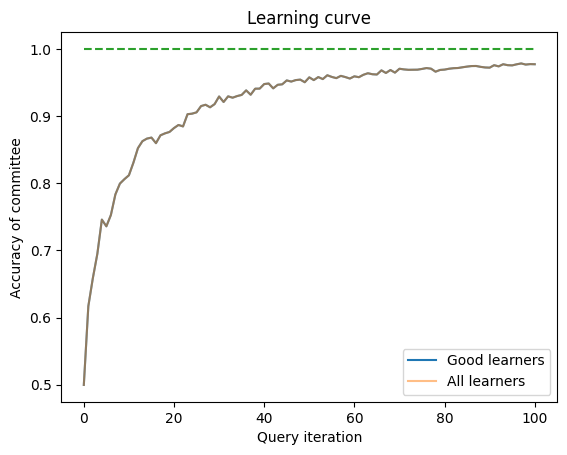

In [46]:
avg_total_perf_hist, avg_good_perf_hist = run_experiments('random', n=500, q=100, repeat=20, query_strategy='random')
plot_learning_curve(avg_total_perf_hist, avg_good_perf_hist)

### $\beta = 0$

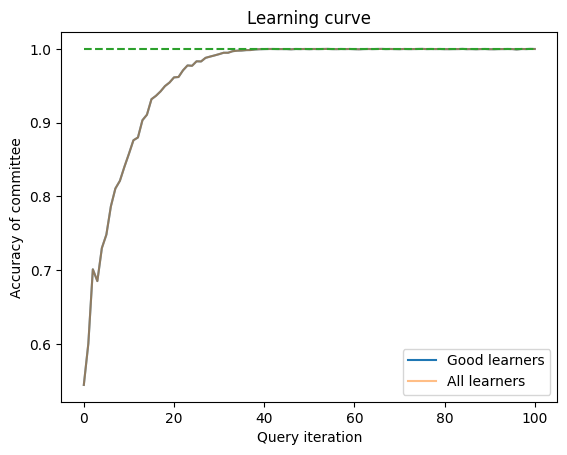

In [24]:
avg_total_perf_hist, avg_good_perf_hist = run_experiments('random', n=500, q=100, repeat=20)
plot_learning_curve(avg_total_perf_hist, avg_good_perf_hist)

### $\beta = 0.5$, flip w.p. $0.5$

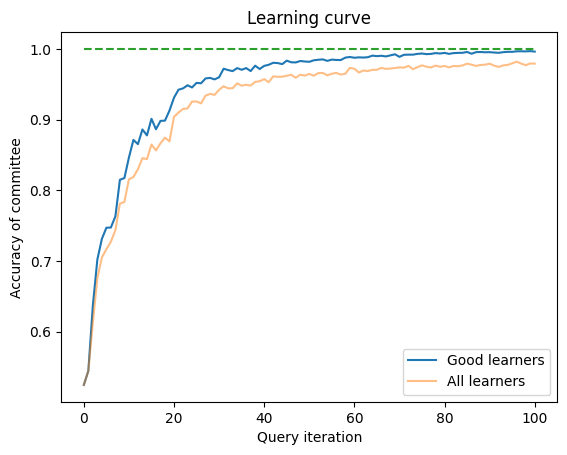

In [29]:
avg_total_perf_hist, avg_good_perf_hist = run_experiments('random', n=500, q=100, repeat=20, beta=0.5, byzantine_proba=0.5, byzantine_mode='flip')
plot_learning_curve(avg_total_perf_hist, avg_good_perf_hist)

### $\beta = 0.6$, flip w.p. $0.5$

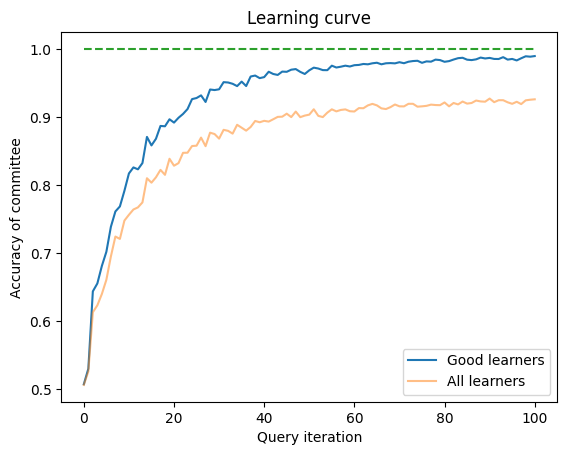

In [30]:
avg_total_perf_hist, avg_good_perf_hist = run_experiments('random', n=500, q=100, repeat=20, beta=0.6, byzantine_proba=0.5, byzantine_mode='flip')
plot_learning_curve(avg_total_perf_hist, avg_good_perf_hist)

### $\beta = 0.6$, random w.p. $0.5$

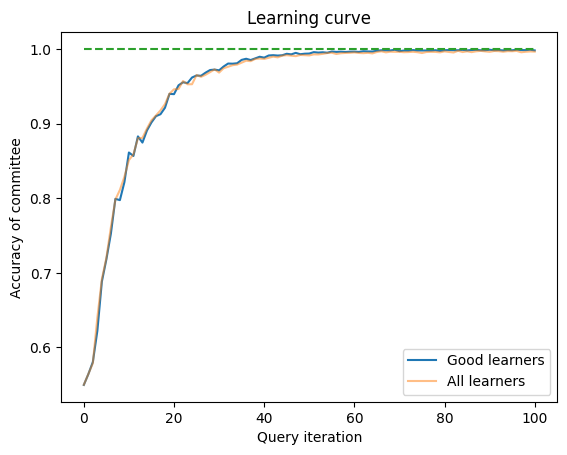

In [39]:
avg_total_perf_hist, avg_good_perf_hist = run_experiments('random', n=500, q=100, repeat=20, beta=0.6, byzantine_proba=0.5, byzantine_mode='rand')
plot_learning_curve(avg_total_perf_hist, avg_good_perf_hist)

### $\beta = 0.8$, random w.p. $0.5$

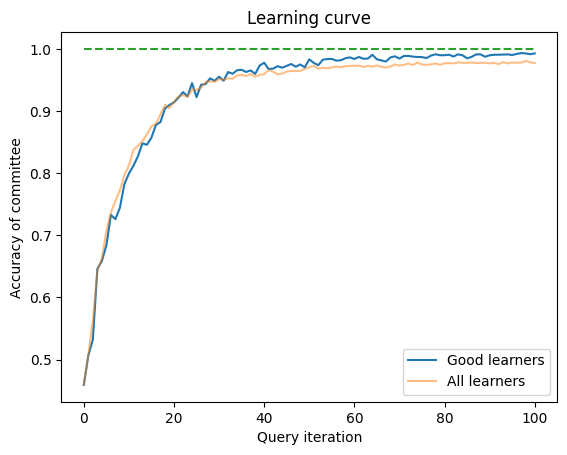

In [41]:
avg_total_perf_hist, avg_good_perf_hist = run_experiments('random', n=500, q=100, repeat=20, beta=0.8, byzantine_proba=0.5, byzantine_mode='rand')
plot_learning_curve(avg_total_perf_hist, avg_good_perf_hist)